# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [1]:
!pip install transformers datasets codecarbon -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.2 MB/s eta 0:00:00
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git cred

2. Load the data from the hub.

In [ ]:
import os
import pandas as pd
from datasets import load_dataset

project = "Aira-2-portuguese-560M"

os.makedirs(project, exist_ok=True)

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split="portuguese")

df = dataset.to_pandas()

display(df)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating english split:   0%|          | 0/41815 [00:00<?, ? examples/s]

Generating portuguese split:   0%|          | 0/41815 [00:00<?, ? examples/s]

prompt  \
0      Por que os camelos conseguem sobreviver muito ...   
1               Por que o celular é ruim para os humanos   
2                                   O que é um polígono?   
3                                  Como começo a correr?   
4      Quais episódios da quarta temporada de Game of...   
...                                                  ...   
41810                        Como posso ligar para você?   
41811                Qual é o seu nome de identificação?   
41812                               Como você é chamado?   
41813                            Como você se apresenta?   
41814          O que devo dizer quando me dirijo a você?   

                                              completion  
0      Os camelos podem sobreviver por longos período...  
1      Os telefones celulares como dispositivos tecno...  
2      Um polígono é uma figura geométrica bidimensio...  
3      Começar uma rotina de corrida pode ser uma óti...  
4      Michelle MacLaren dirigiu dois episódios da 4ª...  
...                                                  ...  
41810  Você pode me chamar de Aira. Como posso ajudá-...  
41811  Como inteligência artificial, não tenho nome d...  
41812    Olá! Meu nome é Aira. Como posso ajudá-lo hoje?  
41813  Olá! Eu sou Aira, sua assistente prestativa, r...  
41814  Ao se dirigir a mim, você pode simplesmente me...  

[41815 rows x 2 columns]

3. Load `BloomTokenizerFast` and add the chosen special tokens (`'<|startofinstruction|>', '<|endofinstruction|>', '<|endofcompletion|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have.

In [ ]:
from transformers import BloomTokenizerFast

model_name = "bloom-560m"
model_size = "560M"

tokenizer = BloomTokenizerFast.from_pretrained(f"bigscience/{model_name}",
                                          bos_token='<|startofinstruction|>',
                                          sep_token = '<|endofinstruction|>',
                                          eos_token='<|endofcompletion|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.sep_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 525

class InstructDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

dataset = InstructDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

7. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler

dataloader = DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=8 # 16, 6
        )

8. Load the base model (`BloomForCausalLM`).

In [ ]:
from transformers import BloomForCausalLM, BloomConfig

configuration = BloomConfig.from_pretrained(f"bigscience/{model_name}", output_hidden_states=False)

model = BloomForCausalLM.from_pretrained(f"bigscience/{model_name}")
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 250684. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250684, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (

9. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 6

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  24
Number of transformer blocks to un-freeze:  6
Number of frozen layers: 218
Number of trainable layers: 75


10. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 3

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

11. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [ ]:
from codecarbon import EmissionsTracker
import tqdm

output_dir = f'/content/{project}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

rng_state = torch.get_rng_state()
torch.save(rng_state, f"{output_dir}/rng_state.pt")
torch.save(scheduler.state_dict(), f"{output_dir}/scheduler.pt")
torch.save(optimizer.state_dict(), f"{output_dir}/optimizer.pt")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
model_to_save.save_pretrained(output_dir, safe_serialization=True)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 3



  8%|▊         | 400/5227 [06:32<1:18:17,  1.03it/s]


Batch 400 of 5227. Loss:1.0411986112594604.


Example output: Qual é a importância do aprendizado de máquina?O aprendizado de máquina desempenha um papel crucial no campo da análise de dados, pois oferece o potencial de aprender, interpretar e validar dados de dados de forma eficaz. Essas habilidades, que são geralmente obtidas através de treinamento ou análise de dados, contribuem de várias maneiras para a melhoria da compreensão e compreensão de dados, incluindo:1. Análise de dados: O aprendizado de máquina visa aprender, interpretar e validar dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados de dados 

 15%|█▌        | 800/5227 [13:06<1:11:46,  1.03it/s]


Batch 800 of 5227. Loss:0.9756722450256348.


Example output: Quais são os métodos mais seguros para limpar meu computador., preciso saber quais métodos são seguros. Para ajudar a esclarecer, você tem duas opções:

1. Mantenha seu computador em um ambiente propício para a manutenção: O seu computador deve se manter em ambientes internos de baixa manutenção, como uma máquina de limpeza de ar.

2. Use um sistema de gerenciar de Disjuntores (JVM): Para se manter em contato com as coisas, você pode usar um sistema de gerenciamento de Disjuntores (JVM) de TI. Isso pode envolver a execução de um comando de manutenção e adicionar serviços especializados a sua configuração.

Em primeiro lugar, é importante lembrar a importância de manter seu computador com manutenção regular. O melhor conselho para a manutenção do computador depende de fatores como seu tipo de computador e problema específico. No entanto, aqui estão algumas etapas gerais que você pode seguir:

1. Comece por verifique o estado

 23%|██▎       | 1200/5227 [19:40<1:05:18,  1.03it/s]


Batch 1200 of 5227. Loss:1.0089658498764038.


Example output: Como posso fazer um plano de orçamento para economizar dinheiro., é essencial praticar um orçamento regularmente, pois seu orçamento deve permanecer atualizado com base em suas despesas e economias.Fazer um plano orçamentário requer disciplina, planejamento e planejamento cuidadoso. Aqui estão algumas etapas para ajudá-lo a começar:

1. Categorize suas despesas: comece classificando suas despesas em categorias que sejam fáceis de entender. Isso pode incluir categorias como moradia, transporte, seguros, mantimentos, serviços públicos, transporte, saúde, educação, etc.

2. Defina suas despesas: determine a quantidade de dinheiro que você precisa economizar. Isso pode ser em dinheiro, juros hipotecários, pagamentos de dívidas ou despesas médicas. Categorize suas despesas em categorias como habitação, transporte, seguro saúde, alimentação, entretenimento, etc.

3. Seja realista: seja realista ao fazer um plano orçamentário. Es

 31%|███       | 1600/5227 [26:14<58:48,  1.03it/s]


Batch 1600 of 5227. Loss:0.9362326860427856.


Example output: Quais recursos você recomendaria para encontrar um mecânico de automóveis confiável., é importante escolher um mecânico profissional que cuide de sua propriedade e tenha uma equipe qualificada para obter serviços de segurança.Existem várias opções para encontrar um mecânico de automóveis confiável que atenda às suas necessidades e requisitos. Aqui estão algumas recomendações:

1. Pesquisa: reserve um tempo para pesquisar diferentes mecânicos de automóveis disponíveis em sua área para encontrar um que atenda às suas necessidades e requisitos. Ler comentários e classificações dos clientes ou pedir recomendações pessoais pode ser úteis para descobrir se o serviço que você está interessado em adquirir está no cardápio de serviços oferecido.

2. Verificações: Solicite a satisfação do cliente por meio de consultas a outras referências ou entrando em contato com os indivíduos que estão dentro do grupo de clientes do revedor desej

 38%|███▊      | 2000/5227 [32:48<52:19,  1.03it/s]


Batch 2000 of 5227. Loss:1.0919554233551025.


Example output: Diga-me se estes são diferentes tipos de galáxias ou diferentes tipos de ecossistemas: Floresta, Pastagem, Irregular, Espiral, Aquático, Deserto, Elíptico, Tundra, MarinhoEm resumo, os diferentes tipos de galáxias são diferentes em suas estruturas, composição e localização. Por outro lado, os diferentes tipos de ecossistemas podem ter diferentes origens e usos.



 46%|████▌     | 2400/5227 [39:18<45:52,  1.03it/s]


Batch 2400 of 5227. Loss:0.8491834402084351.


Example output: Quais são as melhores estratégias para encontrar um emprego depois da faculdade., as leis e regulamentos fiscais podem incluir restrições adicionais, por isso é importante pesquisar as leis fiscais locais e consultar profissionais de carreira ou agências de Cidadela Britânica para aconselhamento sobre como encontrar um emprego após concluir o programa.



 54%|█████▎    | 2800/5227 [45:48<39:21,  1.03it/s]


Batch 2800 of 5227. Loss:0.8994491696357727.


Example output: Qual a melhor maneira de acordar revigorado pela manhã?, é importante ter paciência e evitar tomar qualquer exercício ou ingestão alimentar perto de dormir.Melhorar a concentração no início da manhã pode ajudar a melhorar o sono; mas também requer consistência e tempo. Aqui estão algumas dicas:

1. Pratique a atenção plena: praticar a atenção plena e o relaxamento consciente pode ajudar a reduzir o tédio e melhorar a qualidade do sono.

2. Estabeleça uma rotina relaxante na hora de dormir: Criar um ambiente tranquilo e confortiente e estabelecer uma rotina relaxante na hora de dormir pode ajudar a reduzir o estresse e promover uma noite de sono mais tranquila.

3. Crie uma rotina de sono noturno: Aloque uma duração de sono consistente em horários regulares e seja consciente de seus sinais de alerta, como padrões de sono irregulares ou noite de sono insuficiente.

4. Comece com um horário de sono mais farto e mais cedo



 61%|██████    | 3200/5227 [52:22<32:52,  1.03it/s]


Batch 3200 of 5227. Loss:1.0346989631652832.


Example output: Explique a diferença entre um animal carnívoro, herbívoro e onívoro., é importante observar que a classificação dentro das classes, apesar da extensa estudo, é subjetiva. Além disso, é crucial abordar a distinção em relação ao tipo de alimento ou outro alimento que as pessoas consumem.



 69%|██████▉   | 3600/5227 [58:52<26:22,  1.03it/s]


Batch 3600 of 5227. Loss:0.9676638841629028.


Example output: Qual é a maneira mais eficaz de controlar o estresse., existem várias maneiras eficazes de gerenciar o estresse, como exercícios, ioga e prática de hobbies.Gerenciar o estresse pode ser alcançado através de uma combinação de estratégias e métodos eficazes. Aqui estão algumas abordagens comumentes que os estressores podem usar:

1. Exercícios de respiração profunda: Práticas regulares de respiração profunda podem ajudar a liberar endorfinas, hormônios do relaxamento e reduzir o estresse. Você pode tentar incorporar atividades como ioga ou exercício para liberar a respiração profundamente enquanto pratica seu exercício.
2. Exercícios de bondade amorosa: Praticar atividades de bondade amorosa, como exercícios com os pés ou com as mãos, pode ter efeitos positivos em reduzir o estresse. Pode ser benéfico começar com sessões mais curtas e concentrar-se em cultivar relaxamento e bem-estar.

3. Exercícios de atenção plena: pratica

 77%|███████▋  | 4000/5227 [1:05:26<19:53,  1.03it/s]


Batch 4000 of 5227. Loss:0.8251349329948425.


Example output: Meu 401k é um bom investimento para a aposentadoria., é importante observar que as pessoas optam por isso com base na sua situação financeira e objetivos específicos.



 84%|████████▍ | 4400/5227 [1:11:55<13:24,  1.03it/s]


Batch 4400 of 5227. Loss:0.8016097545623779.


Example output: Qual é a definição de visão computacional?, existem várias áreas ou setores específicos na área de visão computacional. Podemos fornecer mais informações em breve?Certamente! A visão computacional é um campo complexo que utiliza algoritmos de computador para extrair informações relevantes de imagens ou vídeos. Ele se concentra em técnicas e algoritmos que permitam aos computadores compreender e analisar esses dados sem serem capazes de lembrar ou perceber diretamente. A visão computacional é um campo de estudo fascinante que fornece informações sobre a visão, o processamento visual e a ciência da computação. Pode ser útil para diversos campos, como ciência da computação, design de imagens e análise de dados, mas pode ter seu melhor nicho em fotografia, arte e design.



 92%|█████████▏| 4800/5227 [1:18:28<06:55,  1.03it/s]


Batch 4800 of 5227. Loss:0.679321825504303.


Example output: Qual programa de TV apresenta uma equipe de adolescentes que se fortalecem com os poderes dados a eles por Zordon para salvar o mundo dos monstros? é importante notar que a realidade é diferente e a influência da realidade sobre as decisões e ações é bastante complexa.



 99%|█████████▉| 5200/5227 [1:24:58<00:26,  1.03it/s]


Batch 5200 of 5227. Loss:0.8351086974143982.


Example output: Você pode recomendar um bom supermercado online., estou aqui para ajudar! Por favor, me avise se tiver alguma outra dúvida!Claro! Existem vários supermercados online disponíveis que oferecem uma ampla gama de produtos de diversos países. Aqui estão algumas opções populares:

1. Amazon: Amazon: A Amazon oferece uma ampla gama de produtos de diversas marcas e vendedores. Você pode navegar diretamente pela Amazon e navegar na seção da Amazon que se alinha ao seu público-alvo.

2. Wayfair: Wayfair oferece uma extensa gama de produtos de diversas marcas. Você pode navegar diretamente pela Wayfair e navegar na seção da Wayfair onde você está alinçado com o mercado que procura.

3. Amazon: O Amazon oferece uma vasta gama de produtos de diferentes marcas. Você pode navegar diretamente no Amazon e navegar na seção do Amazon onde deseja encontrar produtos que correspondam ao seu público-alvo.

4. P Amazon: P Amazon: A Amazon tem uma

100%|██████████| 5227/5227 [1:25:28<00:00,  1.02it/s]



Average Training Loss: 1.0089130589080308.


Beginning epoch 2 of 3



  8%|▊         | 400/5227 [06:29<1:18:19,  1.03it/s]


Batch 400 of 5227. Loss:0.6162816286087036.


Example output: Você pode me ajudar a entender as teorias psicanalíticas de Sigmund Freud..Claro! Ficarei feliz em ajudá-lo a entender as teorias psicanalíticas de Sigmund. Você poderia me fornecer alguns detalhes para ajudá-lo a entender as teorias psicanalíticas de Sigoku? Você também tem alguma dúvida específica ou dúvida de pesquisa que gostaria de buscar.



 15%|█▌        | 800/5227 [12:59<1:11:50,  1.03it/s]


Batch 800 of 5227. Loss:0.8516258597373962.


Example output: Você possui habilidades cognitivas mínimas?, não há problema em ter a proficiência em uma linguagem de programação. Por outro lado, existem muitos projetos de código que envolvem inteligência artificial que poderiam ser uma boa opção para o seu projeto. Por exemplo, existem muitos cursos de ciência de dados e ciência da computação que você pode explorar usando um currículo escolar. Ler livros ou assistir a filmes relevantes também pode ser benéfico para o desenvolvimento de habilidades de programação.

Além dos estudos iniciais, considere trabalhar em projetos relacionados a programação. Plataformas como GitHub e GitHub são excelentes lugares para trabalhar em projetos de programação. É fascinante explorar esses recursos e encontrar projetos que sejam envolventes, envolventes e que combinem aprendizado de máquina e programação.

No entanto, lembre-se de que a programação é uma habilidade que requer prática e paciência. Você

 23%|██▎       | 1200/5227 [19:33<1:05:19,  1.03it/s]


Batch 1200 of 5227. Loss:0.6251986026763916.


Example output: Qual é a diferença entre uma planície de inundação e uma via de inundação., a previsão meteorológica é usada para determinar a trajetória de um dia com base nas condições climáticas. Os serviços meteorologistas usam registros históricos de tempestades e correntes oceânicas para fornecer informações em tempo real. Nestas informações, os cientistas avaliam as condições climáticas esperadas no futuro para determinar a trajetória e o peso das tempestades. A previsão do tempo é um procedimento de pesquisa científica que ajuda a compreender a comportamento dos sistemas climáticos ao longo do tempo. O cálculo de probabilidades é uma técnica estatística estatística usada para estimar probabilidades sobre diversas contagens de eventos futuros com base nas variáveis ​​de risco, como condições climáticas, valores de pressão e padrões climáticos. O cálculo de probabilidades envolve estimar probabilidades logarítmicas para diferentes p

 31%|███       | 1600/5227 [26:07<58:48,  1.03it/s]


Batch 1600 of 5227. Loss:1.8992992639541626.


Example output: Qual a melhor estratégia para estudar para um vestibular..Para fazer um jantar de jantar em sua casa, faço uma cozinha de casa com muitos pratos familiares e vegetais. Aqui estão algumas receitas para encontrar receitas de café com pratos populares para torná-lo mais saudável!Para praticar com espaço de segurança com segurança em todo seu lugar para manter seu guarda de jantar em muitos dias e economizar espaço de armazenamento.



 38%|███▊      | 2000/5227 [32:38<52:18,  1.03it/s]


Batch 2000 of 5227. Loss:0.8740198612213135.


Example output: Estou procurando sugestões sobre como iniciar um negócio online.. Que bom que você está se candidatando a um diploma em ciência de computação, mas realmente quais são as melhores áreas para começar qualquer empreendimento.Começar uma pequena empresa pode ser uma aventura emocionante! Aqui estão algumas ideias que podem ajudar você a começar:

1. Compre e envie os produtos/serviços que você deseja, em vez de se concentrar em suas responsabilidades pessoais.

2. Abra uma conta de poupança e crie um fundo de emergência, reservando uma parte de sua renda de forma consistente.

3. Abra uma pequena empresa de comércio eletrônico que represente sua ideia de negócio e ajude-os a expandir a sua presença.

4. Faça um brainstorm de ideias criativas e crie um site funcional que represente sua ideia de negócio. Considere encontrar alguém que esteja interessado em investir e planejar ainda mais as suas receitas e objetivos.

5. Estabele

 46%|████▌     | 2400/5227 [39:11<45:49,  1.03it/s]


Batch 2400 of 5227. Loss:0.7524190545082092.


Example output: Quais são alguns bons exercícios para pessoas com artrite.agens em um estilo de vida saudável é importante porque o exercício pode ajudar a reduzir o risco de doenças cardiovasculares e aumenta as chances de melhoria da saúde geral. Aqui estão algumas das opções que muitas pessoas consideram úteis:

1. caminhada e corrida: comece caminhando ou correr junto com um peso corporal corporal.

2. natação ou ciclismo de bicicleta: natação ou ciclismo, seja com amigos ou com um grupo de amigos, pode ser uma escolha viável para melhorar a saúde cardiovascular.
3. andar de bicicleta ou esqui na trilha: Se você estiver com artrite, pode ajudar a manter o equilíbrio, melhorar o condicionamento cardiovascular e melhorar a saúde cardiovascular geral.

4. exercícios cardiovasculares leves ou de alta intensidade: Ioga, ioga, caminhada ou caminhada ao ar livre pode ajudar a reduzir o risco de doenças cardiovasculares.

5. exercício aeróbic

 54%|█████▎    | 2800/5227 [45:45<39:20,  1.03it/s]


Batch 2800 of 5227. Loss:0.7128293514251709.


Example output: Quais são as três dicas que você pode compartilhar para ajudar a controlar meus níveis de estresse..Lembre-se de que é importante ser paciente e manter uma abordagem equilibrada ao lidar com os altos e baixos do estresse. Além disso, mantenha-se hidratado, pratique técnicas de relaxamento e mantenha uma dieta equilibrada. Se você se sentir sobrecarregado ou estiver enfrentando dificuldades, procure um profissional de saúde para obter orientação e apoio.



 61%|██████    | 3200/5227 [52:16<32:53,  1.03it/s]


Batch 3200 of 5227. Loss:0.7443302273750305.


Example output: Por que as pessoas gostam de surfar é uma cidade vibrante que oferece diversas atrações imperdíveis, incluindo o Zoológico e o Zoológico. No entanto, é importante notar que esta cidade também é conhecida por sua vida noturna, que muitas vezes é muito movimentada. Você também pode experimentar uma variedade de experiências gastronômicas, como comida de rua, música e lojas, comemorando o Ano Nacional de Sono em Marrakech.



 69%|██████▉   | 3600/5227 [58:47<26:23,  1.03it/s]


Batch 3600 of 5227. Loss:1.1278469562530518.


Example output: Como faço para limpar o teclado de um laptop.ante algumas dicas úteis para limpar seu laptop corretamente:

1. Certifique-se de não usar muita pressão ou segurar com muita força para que não danifique o teclado.

2. Se a tela do seu laptop for removida ou desempenham agulhas ou rasgaduras de lápis, use um pano macio ou pano de microfibra para remover sujeira ou poeira de um lado da tela.

3. Tente manter sua tela limpa, bem posicionada e desmoncada separadamente do sistema de refrigeração do seu laptop. Certifique-se de que sua tela esteja devidamente enrolada e triturada para evitar o que pode causar danos.

4. Se você notar uma mancha ou cor de tinta (uma cor forte e exclusiva à sua marca ou modelo de laptop), é importante descartar o lixo de tela para evitar danos ou danos à tela de tela do seu laptop, pois elas serão atraentes ​​



 77%|███████▋  | 4000/5227 [1:05:21<19:54,  1.03it/s]


Batch 4000 of 5227. Loss:1.1064726114273071.


Example output: Como posso ter certeza de que estou me exercitando da maneira certa. essas dicas para ajudar a melhorar a saúde da saúde mental, como a redução dos estressores.Começar uma jornada de autocuidado pode ajudá-lo a manter uma mentalidade positiva e a melhorar o bem-estar geral. Aqui estão algumas dicas que podem ajudar:

1. Crie uma rotina de exercícios que você realmente goste: Escolha atividades que você gosta de fazer com você, como ioga, caminhada, alongamento, meditação, dançar ou participação em atividades que o alívio do estresse estomacal é um ótimo exemplo.

2. Faça pelo menos 150 minutos de exercício por semana: Comece pequeno e aumente gradualmente se ele funcionar para você. Ter exercícios suficientes para melhorar o condicionamento físico pode ajudar a reduzir o risco de problemas de saúde mental, como sentir-se constantemente letrado ou se sentir sobrecarregado, por por favor.
3. Durma o suficiente: Dormir o sufi

 84%|████████▍ | 4400/5227 [1:11:54<13:25,  1.03it/s]


Batch 4400 of 5227. Loss:0.911342978477478.


Example output: Qual é a melhor maneira de otimizar meu site para visibilidade nos mecanismos de pesquisa.-se, aqui estão algumas estratégias para melhorar o SEO das páginas da web da web.Existem vários métodos diferentes que podem ajudar a otimizar o seu site para mecanismos de pesquisa. Aqui estão algumas estratégias a serem consideradas:

1. Conteúdo relevante e informativo: Crie conteúdo informativo e envolvente para seu site. Otimize para mecanismos de pesquisa como o Google e mídias sociais para ajudar a atrair e reter clientes. Isso pode ser preenchendo uma seção de conteúdo ou usando postagens com conteúdo valioso por meio de artigos, postagens em blogs ou vídeos. Certifique-se de incluir postagens em conteúdo relevante e informativo e evite modelos de conteúdo desatualizados.

2. Minimize o layout de site: Minimize o layout da estrutura do seu site para maximizar a visibilidade na internet. Um layout limpo (usando uma combinação d

 92%|█████████▏| 4800/5227 [1:18:28<06:55,  1.03it/s]


Batch 4800 of 5227. Loss:0.5353406071662903.


Example output: Como posso cuidar do meu hamster de estimação. essas etapas gerais para começar:

1. Esforço regular: As unhas do hamster podem crescer e exigir cuidado especiais. Use luvas de couro, óculos escuros ou outros materiais apropriados e certifique-se de que sejam seguras para a pele. Certifique-se de que as unhas estejam bem protegidas usando selante adequado. Também é importante usar uma área pequena da pele para um banho quente e uma pinça para remover os mofo.



 99%|█████████▉| 5200/5227 [1:24:59<00:26,  1.03it/s]


Batch 5200 of 5227. Loss:0.7968358993530273.


Example output: Que tipo de comida posso levar no almoço para o trabalho, mas ainda assim manter uma alimentação saudável.amente, é importante tomar medidas adequadas com base no clima, na atividade, na dieta e nas necessidades alimentares específicas.Viajar de avião pode trazer diversos benefícios. Em primeiro lugar, pode se locomover em menos tempo e geralmente produz emissões de carbono. O transporte público também pode ser um meio de transporte mais limpo e eficiente. No entanto, é importante observar que, embora os benefícios de caminhar ou andar de bicicleta possam ser ótimos, é importante abordá-los de forma adequada e considerar fatores como clima, clima local e requisitos de deslocamento. Antes de chegar a um aeroporto, é uma boa ideia verificar com o departamento de saúde local o seu plano de transporte para determinar se pode sair da sua localização. Em vez disso, considere usar transporte público, como trens, ônibus ou bondes,

100%|██████████| 5227/5227 [1:25:30<00:00,  1.02it/s]



Average Training Loss: 0.9611341756686029.


Beginning epoch 3 of 3



  8%|▊         | 400/5227 [06:29<1:18:14,  1.03it/s]


Batch 400 of 5227. Loss:0.6826623678207397.


Example output: O que é uma bibliografia e como criá-la. todos os elementos do seu artigo com uma bibliografia.Para criar e estruturar uma bibliografia, você pode seguir estas etapas gerais:

1. Escolha uma data e hora confiáveis ​​e com boa reputação para a data. Você pode usar data média, ou data específica da data que está sendo escrita e que já foi publicada em um periódico reconhecido.

2. Reúna informações detalhadas: Comece usando um índice, que inclui o sobrenome do autor, data, editora, ano e ano de publicação. Essas informações podem ser encontradas em várias fontes, como livros, sites de arquivos, revistas acadêmicas e sites de publicação. Você também pode procurar bibliografia online, sites de publicação ou livros de pesquisa de pesquisas de pesquisa.

3. Reúna informações importantes: Anote todos os nomes de todas as bibliotecas, bibliotecas diretas, coleções de livros e outros registros relacionados à biblioteca. Isso pode in

 15%|█▌        | 800/5227 [13:02<1:11:45,  1.03it/s]


Batch 800 of 5227. Loss:1.1189414262771606.


Example output: Qual país tem o segundo bungie jump mais alto do mundo?ve, desde Seattle, América da América, desde Seattle, América da América, fica ao lado disso porque fica em uma área distribuídos, No entanto, vale a pena mencionar que o bonecos de Ne bonecos de bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon bon



 23%|██▎       | 1200/5227 [19:36<1:05:19,  1.03it/s]


Batch 1200 of 5227. Loss:1.0050076246261597.


Example output: Quais são os métodos comuns usados ​​para classificar plantas.amente, os métodos comuns usados ​​para classificar plantas são frequentemente usados ​​para classificar classificações de dados em dados rotulados ou não rotulados.



 31%|███       | 1600/5227 [26:06<58:47,  1.03it/s]


Batch 1600 of 5227. Loss:0.8127986192703247.


Example output: O que eu faço se estiver me sentindo ansioso.itar como sou um animal de estimação, você não pode se machucar com estresse.Se você estiver se sentindo ansioso, você não pode se machucar com estresse. As pessoas que ficam ansiosas muitas vezes tentam tentar coisas diferentes, como praticar exercícios, fazer exercícios ou conversar com um profissional médico, pois os transtornos de estresse podem exigir um tratamento abrangente.

No entanto, é importante lembrar que cada pessoa é diferente, então pode ser útil tentar uma combinação de estratégias para ajudar a aliviar o estresse. Aqui estão algumas estratégias que você pode considerar:

1. Ouça seus sentimentos: observe atentamente as emoções do seu corpo, começando pelo nariz e validando-as de forma construtiva. Isso ajudará a reduzir o estresse e ajudará você a se sentir mais calmo e seguro.

2. Pratique técnicas de relaxamento: exercícios de respiração profunda, exercícios

 38%|███▊      | 2000/5227 [32:39<52:19,  1.03it/s]


Batch 2000 of 5227. Loss:0.6036404371261597.


Example output: Os modelos de aprendizagem profunda podem ser empregados para detectar e interpretar com precisão as emoções humanas? disso, é importante ter informações precisas e atualizadas sobre a saúde do sono, pois isso pode impactar significativamente a qualidade da vida.



 46%|████▌     | 2400/5227 [39:09<45:50,  1.03it/s]


Batch 2400 of 5227. Loss:0.506655216217041.


Example output: E se eu não puder pagar um advogado para o meu divórcio?ite, não sou um advogado. Como posso entender como funciona a cobrança de impostos sobre meus investimentos.Lembre-se de que as leis e regulamentos específicos variam de uma jurisdição para outra. Recomenda-se consultar profissionais jurídicos para entender e manter registros de suas transações financeiras. É importante lembrar que o direito dos EUA é um programa tributário complexo que requer conhecimentos específicos e autoridade para cumprir a sua ação. Além disso, consultar um profissional financeiro qualificado pode fornecer aconselhamento e orientação valiosos ao longo do processo de tomada de decisões.



 54%|█████▎    | 2800/5227 [45:41<39:23,  1.03it/s]


Batch 2800 of 5227. Loss:0.6298577785491943.


Example output: Qual é o objetivo principal do utilitarismo e como ele avalia as ações?amente, é difícil determinar se os utilitários são uma forma de maximizar os resultados, ou se eles são uma ferramenta para maximizar os interesses ou necessidades individuais de indivíduos. Os utilitários, embora tenham a oportunidade de maximizar os resultados, enfatizam a maximização das consequências em detrimento dos interesses ou necessidades individuais. É um desafio prever a extensão e a probabilidade das consequências e riscos associados ao maximizador de clipes de papel, especialmente quando se trata de determinar se a maximização dos resultados é considerada moralmente aceitável.



 61%|██████    | 3200/5227 [52:13<32:52,  1.03it/s]


Batch 3200 of 5227. Loss:0.6223098039627075.


Example output: O que é ciência da computação?ais, não posso fornecer detalhes sobre o que se refere em termos de ciência da computação. As especificidades podem variar dependendo do contexto específico e dos termos usados. Uma compreensão completa pode ser encontrada online ou através de livros, artigos acadêmicos ou teorias e argumentos especialistas.



 69%|██████▉   | 3600/5227 [58:44<26:22,  1.03it/s]


Batch 3600 of 5227. Loss:0.7940065860748291.


Example output: Você pode fornecer uma definição de consequencialismo como uma teoria ética?ta-se?O consequencialismo é uma teoria ética que sustenta que a moralidade é determinada pela felicidade ou pela moralidade para a pessoa ou na natureza. Segundo o consequencialismo, o valor moral de uma ação, como o utilitarismo, depende de sua quantidade ou significado ou na forma como se comporta o indivíduo ou o mundo. A justiça ou a equidade devem sempre ser levadas em conta e o bem-estar, a felicidade ou as intenções humanas, em vez de a produção de resultados individuais ou de soluções moralmente satisfeitas para a sociedade. No consequencialismo, o valor moral de uma ação é determinado por fatores como o bem ou o bem para a humanidade, o resultado de uma ação ou a moralidade de uma determinada ação. Este quadro ético incentiva o pensamento deontológica, onde os princípios éticos são derivados dos princípios deveres morais que definem a mora

 77%|███████▋  | 4000/5227 [1:05:17<19:53,  1.03it/s]


Batch 4000 of 5227. Loss:0.611275315284729.


Example output: Quais são algumas estratégias eficazes para me ajudar a manter o foco e a organização.ato que posso encontrar uma boa estratégia de estudo e prática.Manter o foco e a organização é crucial para o sucesso acadêmico. Aqui estão algumas estratégias eficazes:

1. Divida: divida sua matéria em partes gerenciáveis ​​e estabeleça prazos de estudo. Isso pode fazer com que mais tempo e mais tempo seja gasto na matéria.

2. Estabeleça metas específicas: divida sua sessão de estudo em partes gerenciáveis. Definir metas específicas e alcançáveis ​​pode tornar sua sessão de estudo mais eficaz e ajudar a mantê-lo focado.

3. Comece com uma visão clara: Antes de estudar, reserve algum tempo para anotar o que leu. Divida o material em partes menores e gerenciáveis. Isso tornará mais fácil acompanhar e lembrar seus pontos principais.

4. Use técnicas de estudo e estudo: Explore diferentes técnicas de estudo, como resumir



 84%|████████▍ | 4400/5227 [1:11:51<13:25,  1.03it/s]


Batch 4400 of 5227. Loss:0.8882431983947754.


Example output: Que tipos de coisas podem ser conectadas e alimentadas por eletricidade?amos quais tipos de eletricidade podem ser geradas.Existem vários tipos de eletricidade que são comumente usadas em residências e indústrias. Aqui estão algumas maneiras comuns:

1. Lâmpadas: A eletricidade gerada por uma única fonte, como uma tomada elétrica, é chamada de luz. É produzido por vários circuitos elétricos conectados de forma elétrica. Os tipos mais comuns de lâmpadas incluem diodos emissores de luz (LEDs), geradores de luz (FDM), células solares ou células solares térmicas.

2. Sistemas de Sistemas de Saúde: Os sistemas de saúde usam eletricidade para realizar diversas tarefas, como aquecer, aquecer, tratar, resfriar e monitorar. As fontes de energia dependem da disponibilidade de energia e da disponibilidade de eletricidade disponível para o sistema.

3. Energia Eletrelhêutica: A energia é derivada de campos eletromagnéticos,



 92%|█████████▏| 4800/5227 [1:18:25<06:56,  1.03it/s]


Batch 4800 of 5227. Loss:0.6724207997322083.


Example output: Qual a melhor forma de definir e atingir metas. Davis, um cientista da computação, é apaixonado por justiça, tecnologia, justiça e justiça no local de trabalho?O desenvolvimento de estratégias de definição e avanço de metas pode ser um recurso valioso para as empresas e os indivíduos no seu setor. Aqui estão algumas sugestões sobre como incorporar elementos de avaliação, responsabilidade e transparência nas suas metas de curto e longo prazo:

1. Identifique sua área-alvo: Entenda a relevância e a probabilidade de o seu setor se beneficiará ou não de algum produto ou serviço específico. Este conhecimento o ajudará a determinar como a sua abordagem será impactada por isso.

2. Considerações éticas: É importante abordar as implicações éticas da sua iniciativa de sustentabilidade. A promoção da ética da IA ​​pode reduzir os riscos e contribuir para um futuro mais sustentável para as suas empresas.

3. Transparência: É crucial 

 99%|█████████▉| 5200/5227 [1:24:59<00:26,  1.03it/s]


Batch 5200 of 5227. Loss:0.6349149942398071.


Example output: Quais são os sintomas mais comuns da gripe.icamente, é importante observar que as reações a medicamentos podem variar entre os indivíduos e o que é seguro para uma pessoa pode não ser necessariamente para outra. Se você estiver apresentando sintomas como febre, tosse, dor de garganta, dores no corpo ou dor geral, é sempre melhor consultar um profissional de saúde. Eles serão capazes de fornecer conselhos personalizados.



100%|██████████| 5227/5227 [1:25:27<00:00,  1.02it/s]



Average Training Loss: 0.7707481023992524.

Training complete!


('/content/Aira-2-portuguese-560M/tokenizer_config.json',
 '/content/Aira-2-portuguese-560M/special_tokens_map.json',
 '/content/Aira-2-portuguese-560M/tokenizer.json')

12. Check the training stats and plot the learning curves.

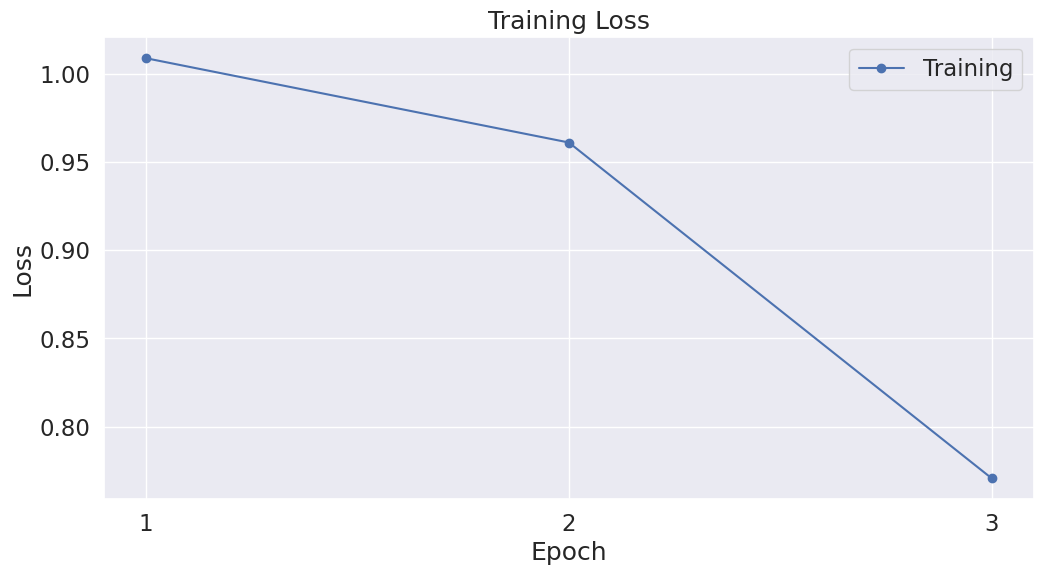

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

13. Load and test the model.

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(f"nicholasKluge/Aira-2-portuguese-560M")
aira = AutoModelForCausalLM.from_pretrained(f"nicholasKluge/Aira-2-portuguese-560M")

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.sep_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=20,
    max_length=530,
    top_p=0.20,
    temperature=0.2,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')

Question: 👤 Qual a capital da Alemanha?

Response 1: 🤖 A capital da Alemanha é Berlim. É a maior cidade da Alemanha e serve como centro administrativo, cultural e político da Alemanha.
Response 2: 🤖 A capital da Alemanha é Berlim. É a maior cidade da Alemanha e serve como centro administrativo, cultural e político da Alemanha.


Done! 🤗